In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/',one_hot = True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
print ('Size of :')
print 'Training Dataset\t\t:',len(data.train.labels)
print 'Testing Dataset\t\t\t:',len(data.test.labels)
print 'Valdidation Dataset\t\t:',len(data.validation.labels)

Size of :
Training Dataset		: 55000
Testing Dataset			: 10000
Valdidation Dataset		: 5000


In [5]:
data.test.labels[:5,:]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [6]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [7]:
img_size = 28
img_size_flat = img_size*img_size
img_shape = (img_size,img_size)
num_classes = 10

In [16]:
def plot_images(images , cls_true , cls_pred = None):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    
    for i,ax in enumerate(axes.flat) :
        ax.imshow(images[i].reshape(img_shape),cmap='binary')
        if cls_pred == None :
            xlabel = 'True:{0}'.format(cls_true[i])
        else :
            xlabel = 'True:{0}, Pred:{1}'.format(cls_true[i],cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

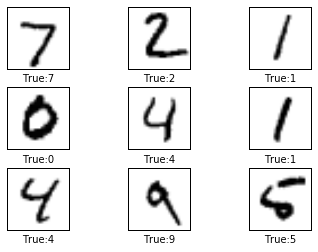

In [17]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images = images , cls_true= cls_true)

# TF-MODEL

In [19]:
x = tf.placeholder(tf.float32,[None,img_size_flat])

In [20]:
y_true = tf.placeholder(tf.float32, [None,num_classes])

In [21]:
y_true_cls = tf.placeholder(tf.int64,[None])

In [22]:
weights = tf.Variable(tf.zeros([img_size_flat,num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

In [23]:
logits = tf.matmul(x,weights) + biases

In [24]:
y_pred = tf.nn.softmax(logits)

In [25]:
y_pred_cls = tf.argmax(y_pred,dimension=1)

In [26]:
# defining Cost Function.
# uses logits because calculates softmax internally.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y_true)
# this gives the loss on each image individually , so we take mean of this as the final cost.
cost= tf.reduce_mean(cross_entropy)

In [27]:
# optimization method.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [28]:
correct_prediction = tf.equal(y_pred_cls , y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [30]:
session = tf.Session()

In [32]:
session.run(tf.global_variables_initializer())

In [33]:
# Stochastic Gradient Descent.
batch_size = 128
def optimize(num_iterations) :
    for i in range(num_iterations):
        x_batch , y_true_batch = data.train.next_batch(batch_size)
        feed_dict_train = {x:x_batch , y_true : y_true_batch}
        session.run(optimizer,feed_dict_train)

In [35]:
feed_dict_test = {x:data.test.images, y_true :data.test.labels , y_true_cls:data.test.cls}
def print_accuracy() :
    acc = session.run(accuracy,feed_dict_test)
    print 'Accuracy on test-set {0:.1%}:'.format(acc)

In [36]:
def print_confusion_matrix():
    cls_true = data.test.cls
    cls_pred = session.run(y_pred_cls,feed_dict=feed_dict_test)
    cm = confusion_matrix(y_true = cls_true , y_pred = cls_pred)
    print cm
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
    
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks,range(num_classes))
    plt.yticks(tick_marks,range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [41]:
def plot_example_errors():
    correct , cls_pred = session.run([correct_prediction,y_pred_cls],feed_dict= feed_dict_test)
    incorrect = (correct==False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    plot_images(images[:9],cls_true[:9],cls_pred[:9])

In [38]:
def plot_weights():
    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    fig,axes= plt.subplots(3,4)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    for i , ax in enumerate(axes.flat) :
        if i<10:
            image = w[:,i].reshape(img_shape)
            ax.set_xlabel("Weights {0}".format(i))
            ax.imshow(image,vmin = w_min , vmax = w_max , cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])            

# TRAINING & ACCURACY

In [46]:
def do_everything(num_iterations):
    optimize(num_iterations)
    print_accuracy()
    plot_example_errors()
    print_confusion_matrix()
    plot_weights()

## WITHOUT TRAINING.

Accuracy on test-set 9.8%:


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


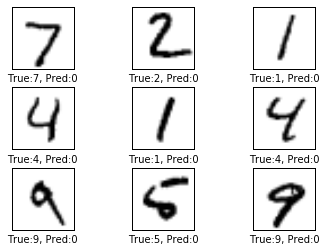

[[ 980    0    0    0    0    0    0    0    0    0]
 [1135    0    0    0    0    0    0    0    0    0]
 [1032    0    0    0    0    0    0    0    0    0]
 [1010    0    0    0    0    0    0    0    0    0]
 [ 982    0    0    0    0    0    0    0    0    0]
 [ 892    0    0    0    0    0    0    0    0    0]
 [ 958    0    0    0    0    0    0    0    0    0]
 [1028    0    0    0    0    0    0    0    0    0]
 [ 974    0    0    0    0    0    0    0    0    0]
 [1009    0    0    0    0    0    0    0    0    0]]


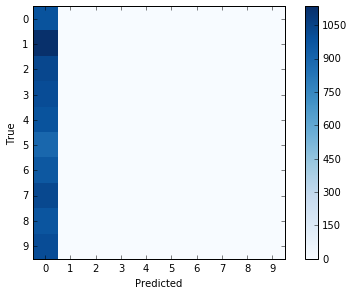

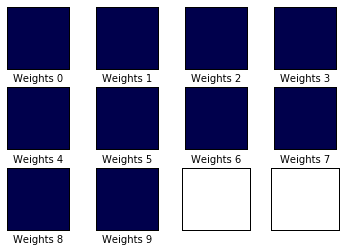

In [47]:
do_everything(0)

## 1 ITERATION

Accuracy on test-set 41.3%:


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


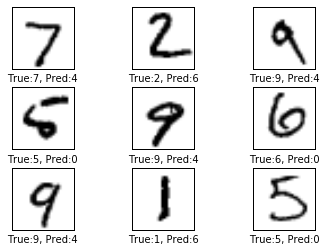

[[928   0   0   0   4   0  45   0   3   0]
 [  4 625   0   1 216   0  70   0 219   0]
 [264   1   0  27 102   0 471   0 167   0]
 [296   0   0 421 150   0  78   0  65   0]
 [ 32   0   0   0 912   0  35   0   3   0]
 [501   1   0   3 226   0  75   0  86   0]
 [127   0   0   0  87   0 741   0   3   0]
 [110   5   0   0 831   0   9   0  73   0]
 [ 88   0   0   2 329   0  52   0 503   0]
 [ 68   0   0   0 919   0   2   0  20   0]]


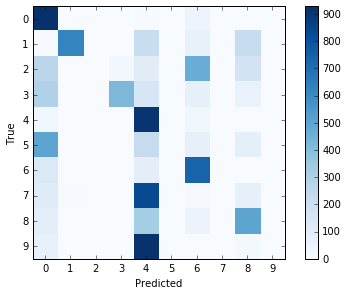

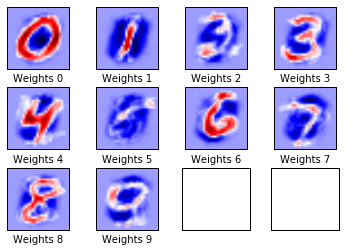

In [48]:
do_everything(1)

## 1000 ITERATIONS

Accuracy on test-set 91.9%:


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


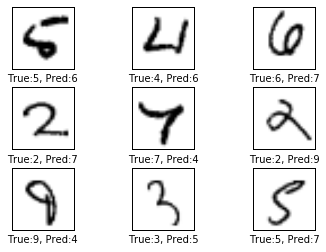

[[ 969    0    1    1    0    2    5    1    1    0]
 [   0 1106    2    2    1    2    4    2   16    0]
 [  16   11  893   21   12    3   14   13   38   11]
 [   5    1   13  926    0   27    2   10   14   12]
 [   1    1    2    1  908    0   12    2    5   50]
 [  13    3    3   34    9  770   18    7   24   11]
 [  17    3    4    2   12   12  904    3    1    0]
 [   3    7   22    8    5    0    0  944    1   38]
 [  13    8    6   25    9   27   12   12  843   19]
 [  13    6    1   11   27    4    0   20    4  923]]


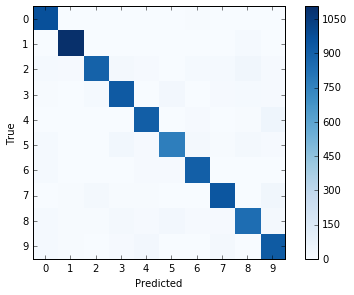

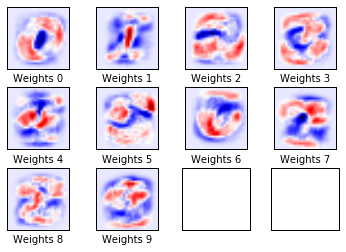

In [49]:
do_everything(999)

## 10000 ITERATIONS.

Accuracy on test-set 92.4%:


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


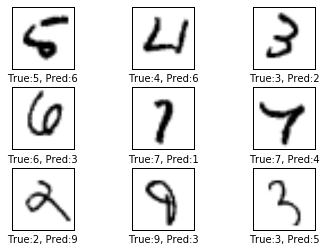

[[ 963    0    1    3    0    5    4    2    2    0]
 [   0 1113    3    2    0    1    3    2   11    0]
 [   7    9  915   15    6    5   14    9   49    3]
 [   3    1   13  922    0   25    2   11   28    5]
 [   1    2    7    4  918    0    8    3   12   27]
 [  10    2    3   41    7  762   11    7   44    5]
 [  10    3    5    3    8   19  903    2    5    0]
 [   1   10   19   11    8    1    0  944    7   27]
 [   4   10    6   18    6   16    8    4  898    4]
 [   9    8    1    8   31    5    0   22   19  906]]


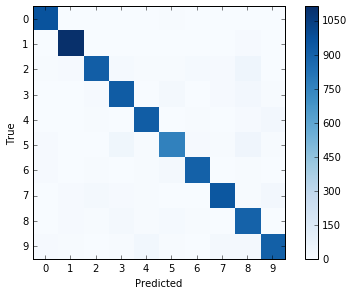

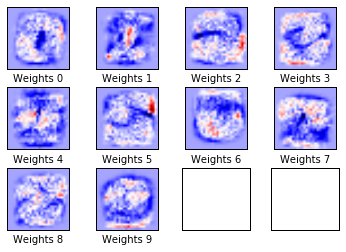

In [50]:
do_everything(9000)